# Barbell Exercise Classifier

In [1]:
#Import Libraries
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor
import outlier_detection
from DataTransformation import LowPassFilter, PrincipalComponentAnalysis
from TemporalAbstraction import NumericalAbstraction
from FrequencyAbstraction import FourierTransformation
from sklearn.cluster import KMeans
from scipy.stats import shapiro
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from LearningAlgorithms import ClassificationAlgorithms
import itertools
from sklearn.model_selection import train_test_split

#plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)


## Data Preprocessing

In [2]:
files = glob("data/raw/MetaMotion/*.csv")

data_path = "data/raw/MetaMotion/"

acc_df = pd.DataFrame()
gyr_df = pd.DataFrame()

acc_set = 1
gyr_set = 1

test = []

for f in files:
    participant = f.split("-")[0].replace(data_path, "")
    label = f.split("-")[1]
    category = f.split("-")[2].split("_")[0].translate(str.maketrans("", "", "0123456789"))
    
    df = pd.read_csv(f)
    
    df["participant"] = participant
    df["label"] = label
    df["category"] = category
    
    if "Accelerometer" in f:
        df["set"] = acc_set
        acc_set += 1
        acc_df = pd.concat([acc_df, df])
        
    if "Gyroscope" in f:
        df["set"] = gyr_set
        gyr_set += 1
        gyr_df = pd.concat([gyr_df, df])
        
acc_df.index = pd.to_datetime(acc_df["epoch (ms)"], unit="ms")
gyr_df.index = pd.to_datetime(gyr_df["epoch (ms)"], unit="ms")
    
del acc_df["epoch (ms)"]
del acc_df["time (01:00)"]
del acc_df["elapsed (s)"]

del gyr_df["epoch (ms)"]
del gyr_df["time (01:00)"]
del gyr_df["elapsed (s)"]

print(gyr_df.info())
print(acc_df.info())
    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47218 entries, 2019-01-15 19:09:07.087000 to 2019-01-18 16:46:23.453000
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x-axis (deg/s)  47218 non-null  float64
 1   y-axis (deg/s)  47218 non-null  float64
 2   z-axis (deg/s)  47218 non-null  float64
 3   participant     47218 non-null  object 
 4   label           47218 non-null  object 
 5   category        47218 non-null  object 
 6   set             47218 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 2.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23578 entries, 2019-01-11 15:42:43.566000 to 2019-01-14 13:50:00.515000
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x-axis (g)   23578 non-null  float64
 1   y-axis (g)   23578 non-null  float64
 2   z-axis (g)   23578 non-null  float64
 3  

In [3]:
print(gyr_df.index[1] - gyr_df.index[0])
print(acc_df.index[1] - acc_df.index[0])

0 days 00:00:00.040000
0 days 00:00:00.080000


We can check that accelerometer data is collected every 0.08 seconds and gyroscope data is collected every 0.04 seconds. It means the data require resampling after merging.

In [4]:
# Merging
data_merged = pd.concat([acc_df.iloc[:, :3], gyr_df], axis=1)

data_merged.head(50)

data_merged.columns = [
    "acc_x",
    "acc_y",
    "acc_z",
    "gyr_x",
    "gyr_y",
    "gyr_z",
    "participant",
    "label",
    "category",
    "set",
]

data_merged

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:04.950,NaN,NaN,NaN,-10.671,-1.524,5.976,B,bench,heavy,64.0
2019-01-11 15:08:04.990,NaN,NaN,NaN,-8.720,-2.073,3.171,B,bench,heavy,64.0
2019-01-11 15:08:05.030,NaN,NaN,NaN,0.488,-3.537,-4.146,B,bench,heavy,64.0
2019-01-11 15:08:05.070,NaN,NaN,NaN,0.244,-5.854,3.537,B,bench,heavy,64.0
2019-01-11 15:08:05.110,NaN,NaN,NaN,-0.915,0.061,-2.805,B,bench,heavy,64.0
...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:35:13.382,-0.060,-1.021,-0.058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-20 17:35:13.462,-0.035,-1.037,-0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-20 17:35:13.542,-0.045,-1.029,-0.033,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Resampling

In [5]:
sampling = {
    "acc_x": "mean",
    "acc_y": "mean",
    "acc_z": "mean",
    "gyr_x": "mean",
    "gyr_y": "mean",
    "gyr_z": "mean",
    "participant": "last",
    "label": "last",
    "category": "last",
    "set": "last",
}

days = [g for n, g in data_merged.groupby(pd.Grouper(freq="D"))]

data_resampled = pd.concat(
    [df.resample(rule="200ms").apply(sampling).dropna() for df in days]
)

data_resampled["set"] = data_resampled["set"].astype("int")

data_resampled.head()


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,64
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,64
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,64
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,64
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,64


Now, accelerometer data and gyroscope data is merged correctly.

## Outlier control

In [6]:
df = data_resampled

outlier_columns = list(df.columns[:6])
df.head(5)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,64
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,64
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,64
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,64
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,64


#### Box Plot to See Outliers

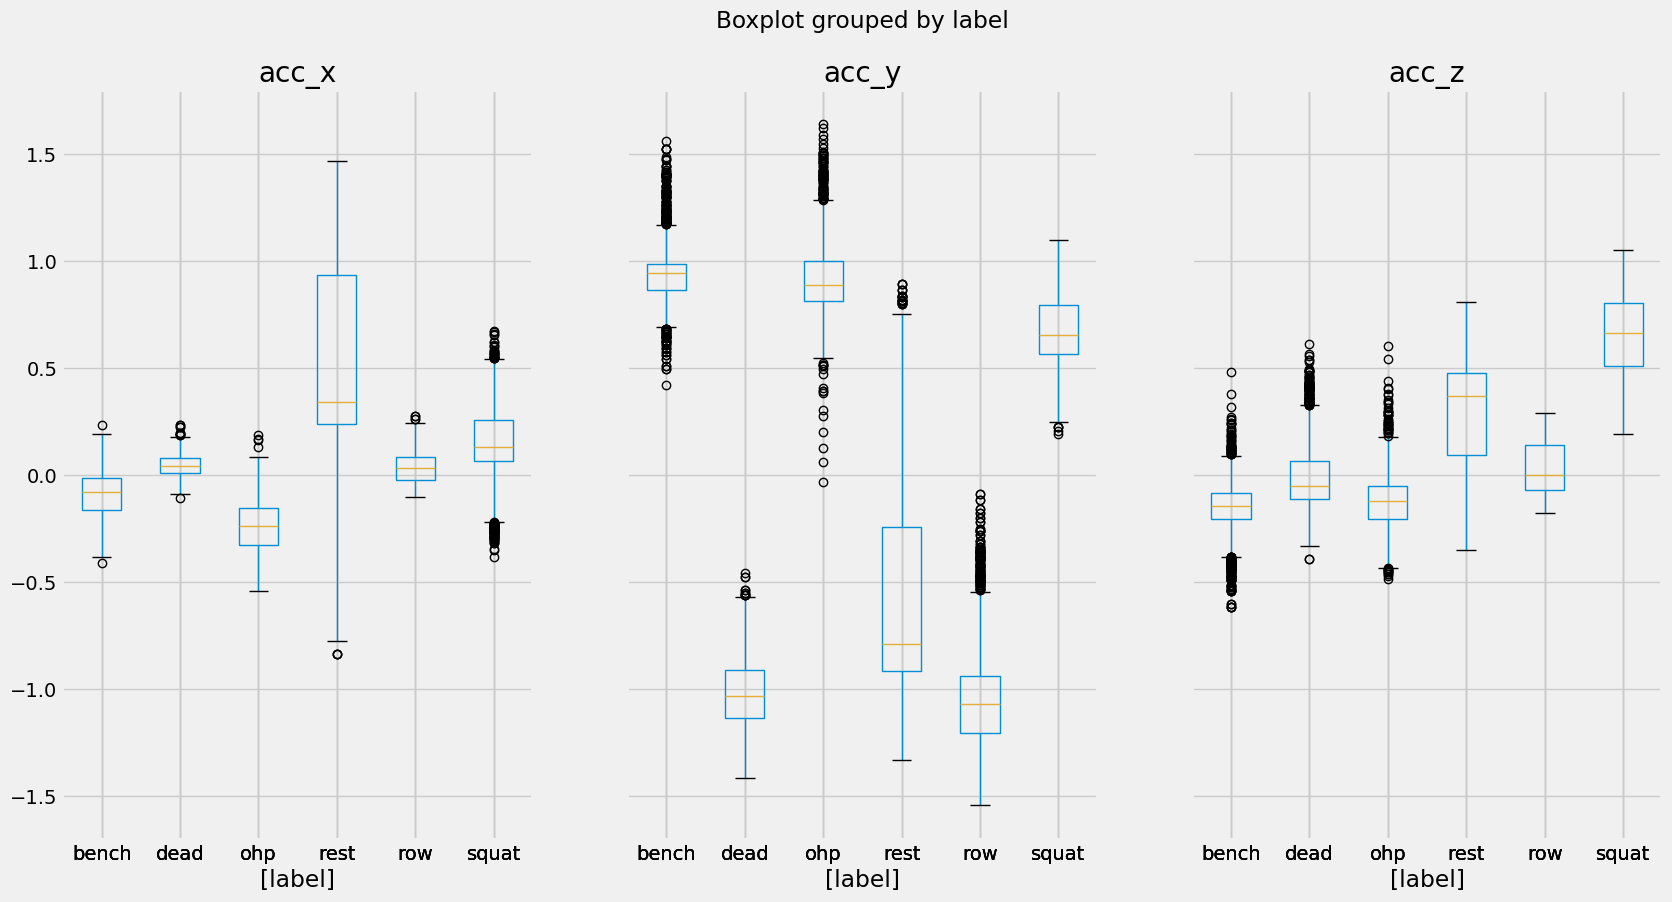

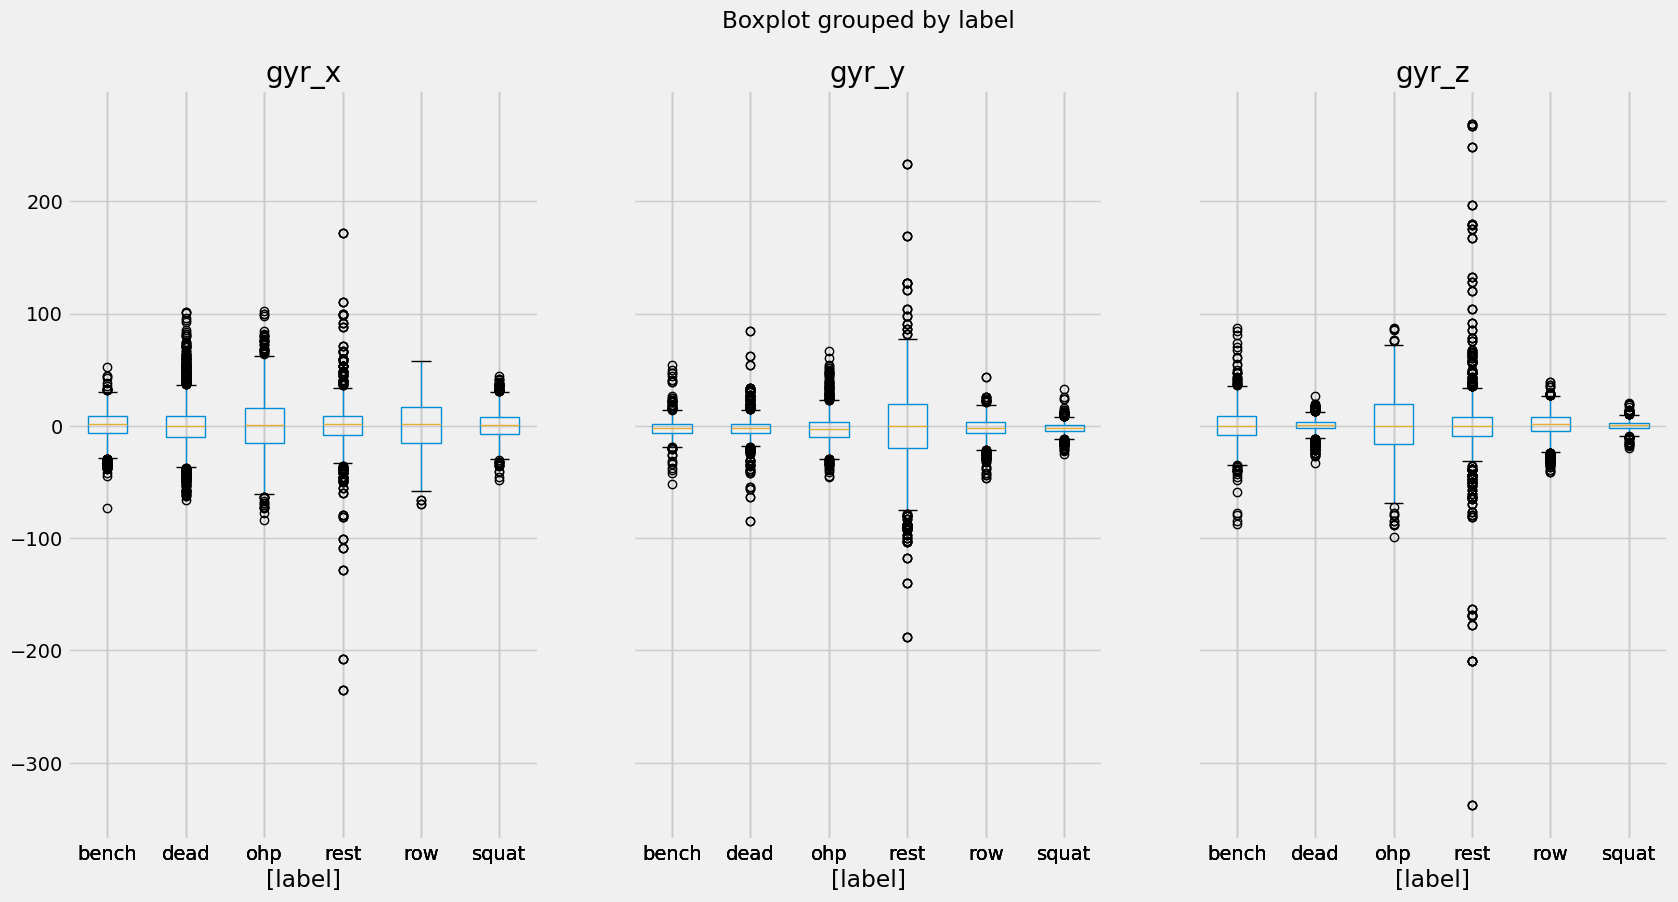

In [7]:
df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1, 3))
plt.show()

#### Statistical Test for Normal Distribution

In [8]:
for label in df["label"].unique():
    for feature in df.columns[0:6]:
        stat, p = shapiro(df[df["label"] == label][feature])
        print(f'Statistic={stat}, p-value={p}')
        if p > 0.05:
            print(f"{label}{feature} is likely normally distributed (fail to reject H0)")
        else:
            print(f"{label}{feature} is not normally distributed (reject H0)")

Statistic=0.9667893138570599, p-value=4.024337987912482e-19
benchacc_x is not normally distributed (reject H0)
Statistic=0.9334929103954136, p-value=1.2849037345396598e-26
benchacc_y is not normally distributed (reject H0)
Statistic=0.9482339892783447, p-value=9.252297154494298e-24
benchacc_z is not normally distributed (reject H0)
Statistic=0.9790412040222414, p-value=6.999584313657826e-15
benchgyr_x is not normally distributed (reject H0)
Statistic=0.9277621385054268, p-value=1.3442356410231142e-27
benchgyr_y is not normally distributed (reject H0)
Statistic=0.9562496124665477, p-value=6.136470497988134e-22
benchgyr_z is not normally distributed (reject H0)
Statistic=0.9878761974462865, p-value=1.224862022807591e-10
ohpacc_x is not normally distributed (reject H0)
Statistic=0.9415244763695969, p-value=3.2966699195201717e-25
ohpacc_y is not normally distributed (reject H0)
Statistic=0.9787822873016095, p-value=4.799363437675266e-15
ohpacc_z is not normally distributed (reject H0)
Stat

The statistical test said that most of the data does not follow normal distribution.
This means we cannot use outlier handling method like Chauvenet's Criterion.
I will simply use IQR method for outlier handling.

##### IQR

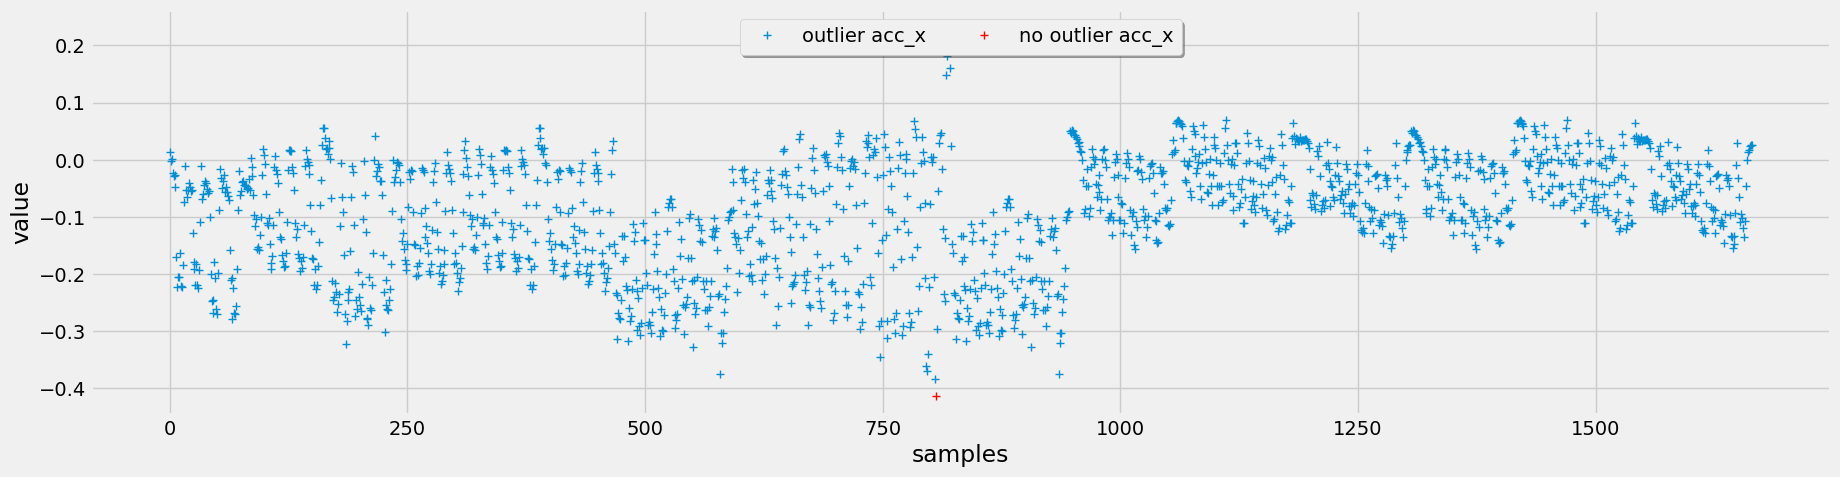

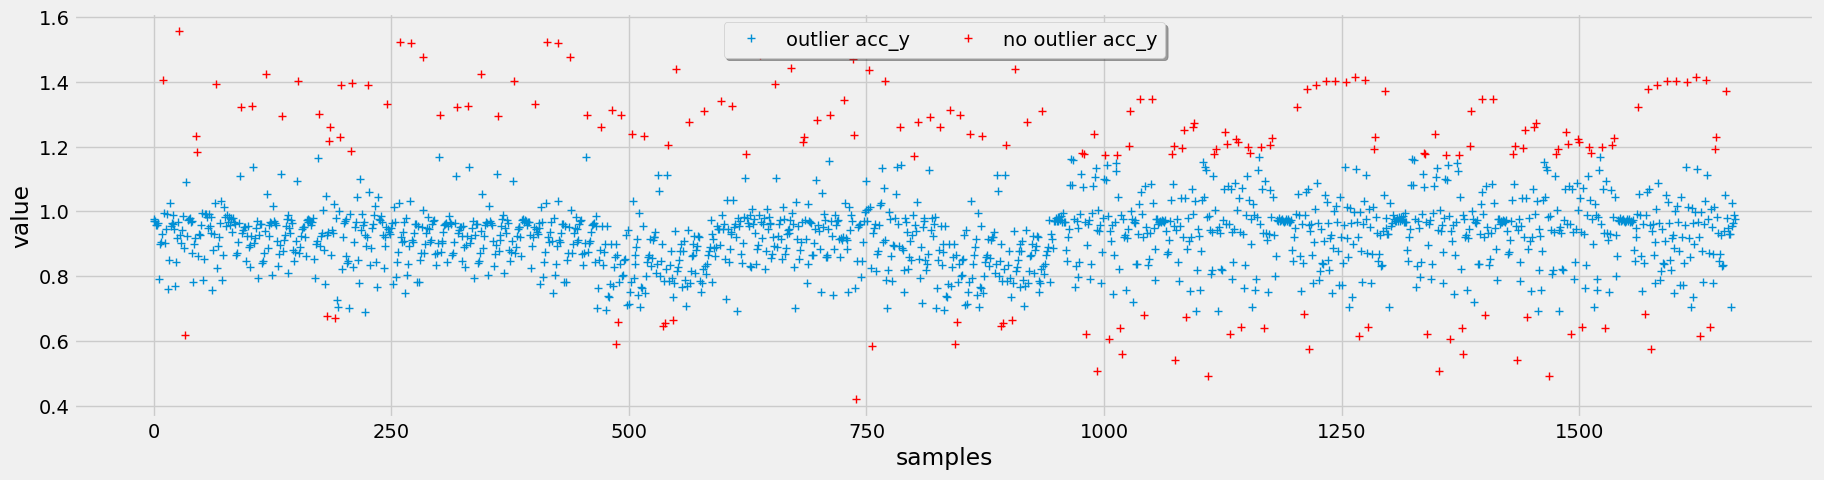

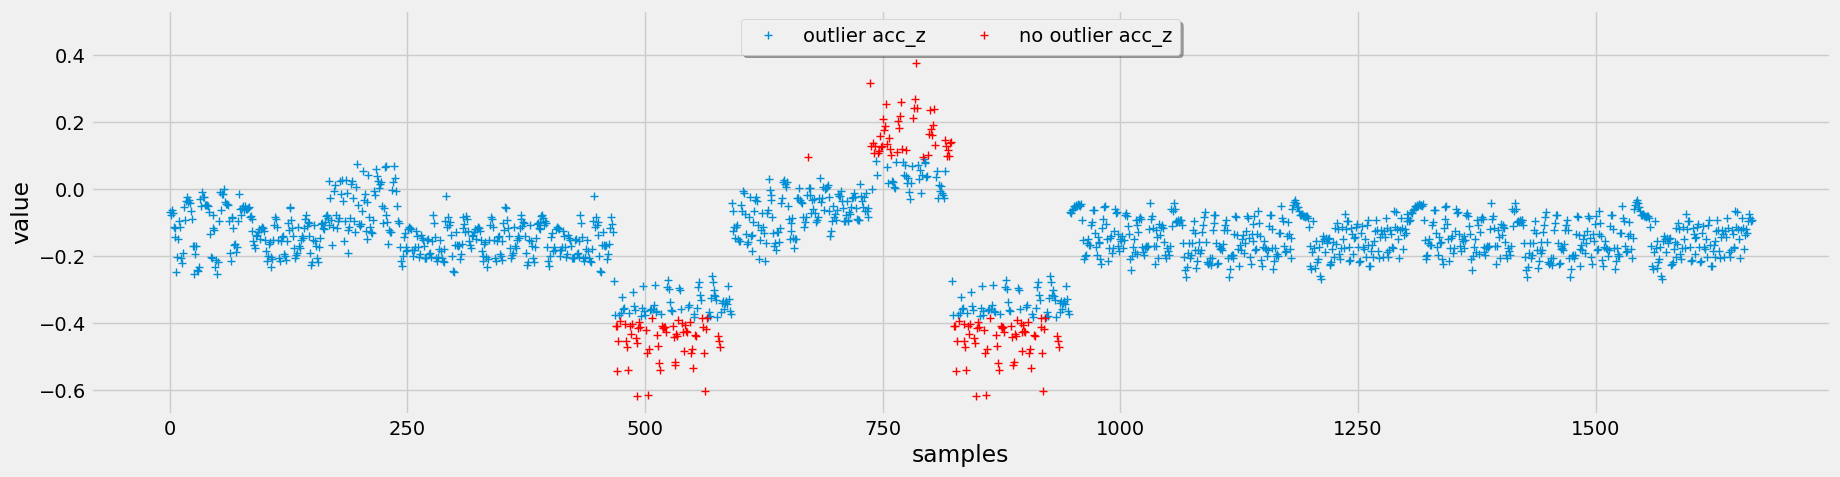

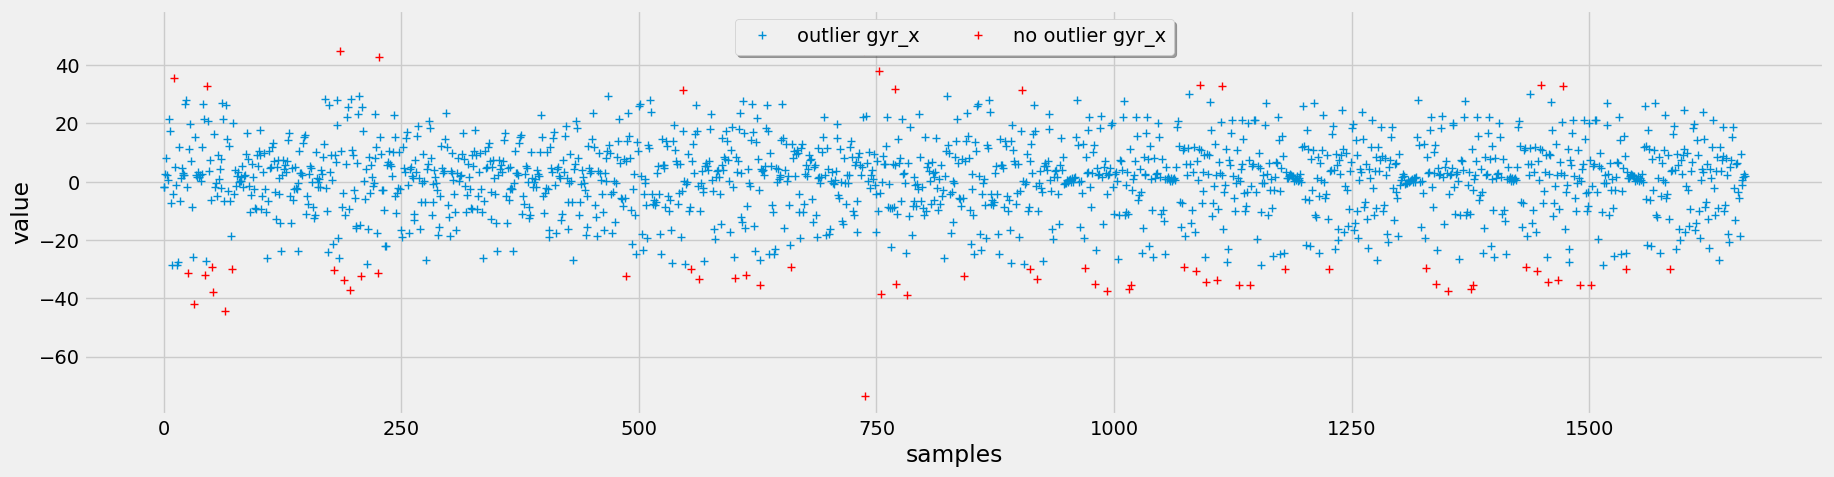

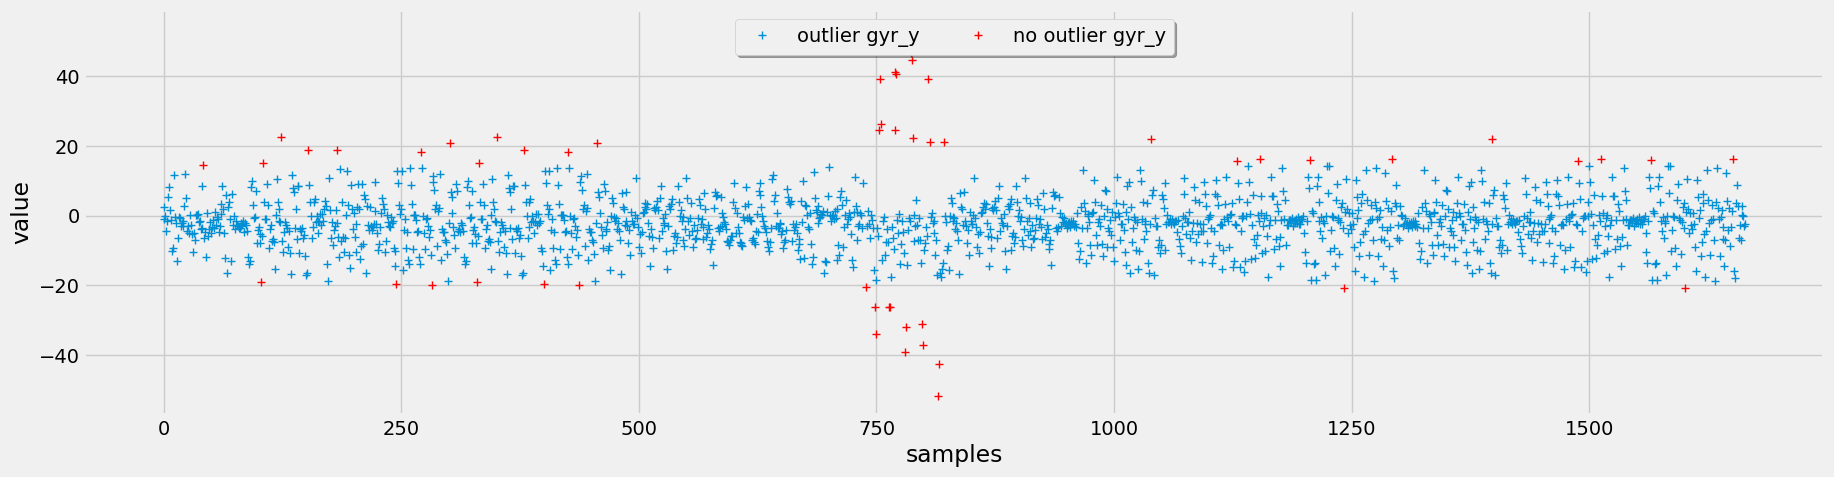

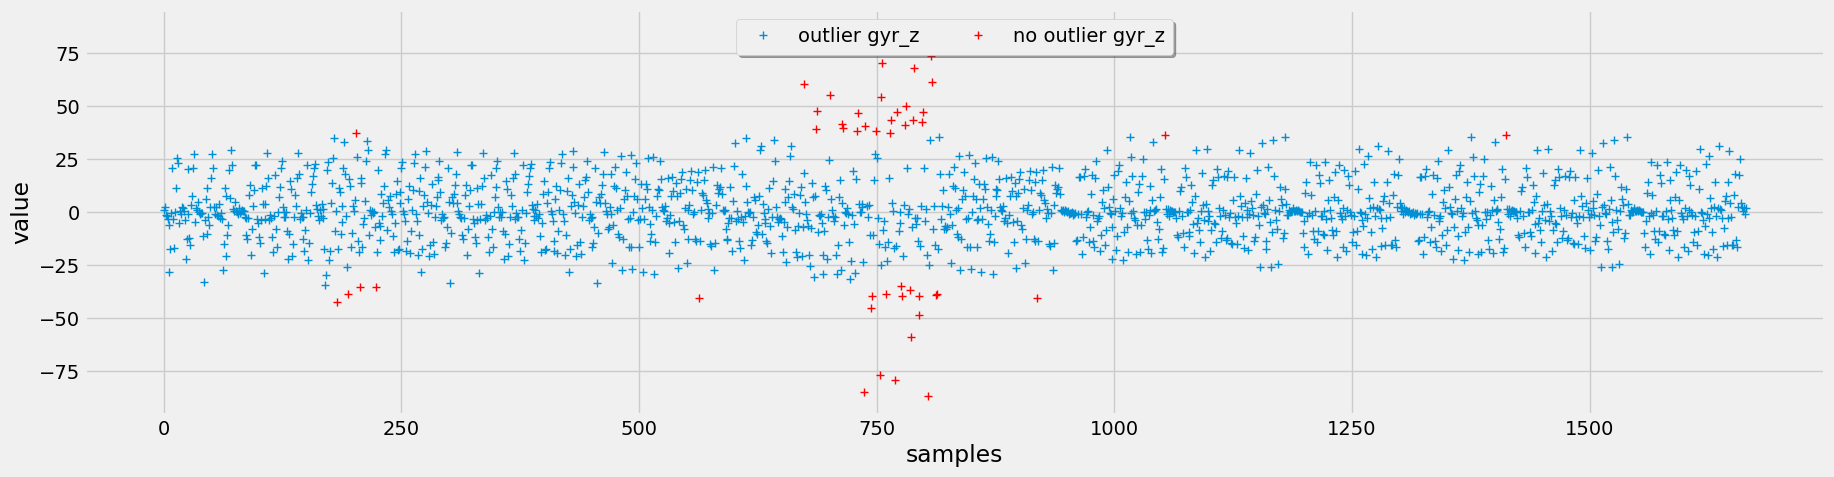

In [9]:
for col in outlier_columns:
    dataset = outlier_detection.mark_outliers_iqr(df[df["label"] == "bench"], col)
    outlier_detection.plot_binary_outliers(
        dataset=dataset, col=col, outlier_col=col + "_outlier", reset_index=True
    )

#### Removing Outliers

In [10]:
outliers_removed_df = df.copy()
for col in outlier_columns:
    for label in df["label"].unique():
        dataset = outlier_detection.mark_outliers_iqr(df[df["label"] == label], col)

        dataset.loc[dataset[col + "_outlier"], col] = np.nan

        outliers_removed_df.loc[(outliers_removed_df["label"] == label), col] = dataset[
            col
        ]

        n_outliers = len(dataset) - len(dataset[col].dropna())
        print(f"Removed {n_outliers} from {col} for {label}")

outliers_removed_df.info()

Removed 2 from acc_x for bench
Removed 4 from acc_x for ohp
Removed 105 from acc_x for squat
Removed 11 from acc_x for dead
Removed 4 from acc_x for row
Removed 3 from acc_x for rest
Removed 191 from acc_y for bench
Removed 107 from acc_y for ohp
Removed 5 from acc_y for squat
Removed 11 from acc_y for dead
Removed 142 from acc_y for row
Removed 24 from acc_y for rest
Removed 168 from acc_z for bench
Removed 53 from acc_z for ohp
Removed 0 from acc_z for squat
Removed 104 from acc_z for dead
Removed 0 from acc_z for row
Removed 0 from acc_z for rest
Removed 66 from gyr_x for bench
Removed 44 from gyr_x for ohp
Removed 52 from gyr_x for squat
Removed 240 from gyr_x for dead
Removed 4 from gyr_x for row
Removed 150 from gyr_x for rest
Removed 56 from gyr_y for bench
Removed 86 from gyr_y for ohp
Removed 97 from gyr_y for squat
Removed 121 from gyr_y for dead
Removed 63 from gyr_y for row
Removed 93 from gyr_y for rest
Removed 50 from gyr_z for bench
Removed 16 from gyr_z for ohp
Removed 

#### Interpolate Missing Values

In [11]:
df = outliers_removed_df

predictor_columns = list(df.columns[:6])

#Missing value handling
for col in predictor_columns:
    df[col] = df[col].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


## Feature Engineering

#### Creating Duration Feature

In [12]:
for s in df["set"].unique():
    start = df[df["set"] == s].index[0]
    stop = df[df["set"] == s].index[-1]

    duration = stop - start
    df.loc[(df["set"] == s), "duration"] = duration.seconds

df.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,64,16.0
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,64,16.0
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,64,16.0
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,64,16.0
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,64,16.0


#### Low Pass Filter to Remove Noise

dead


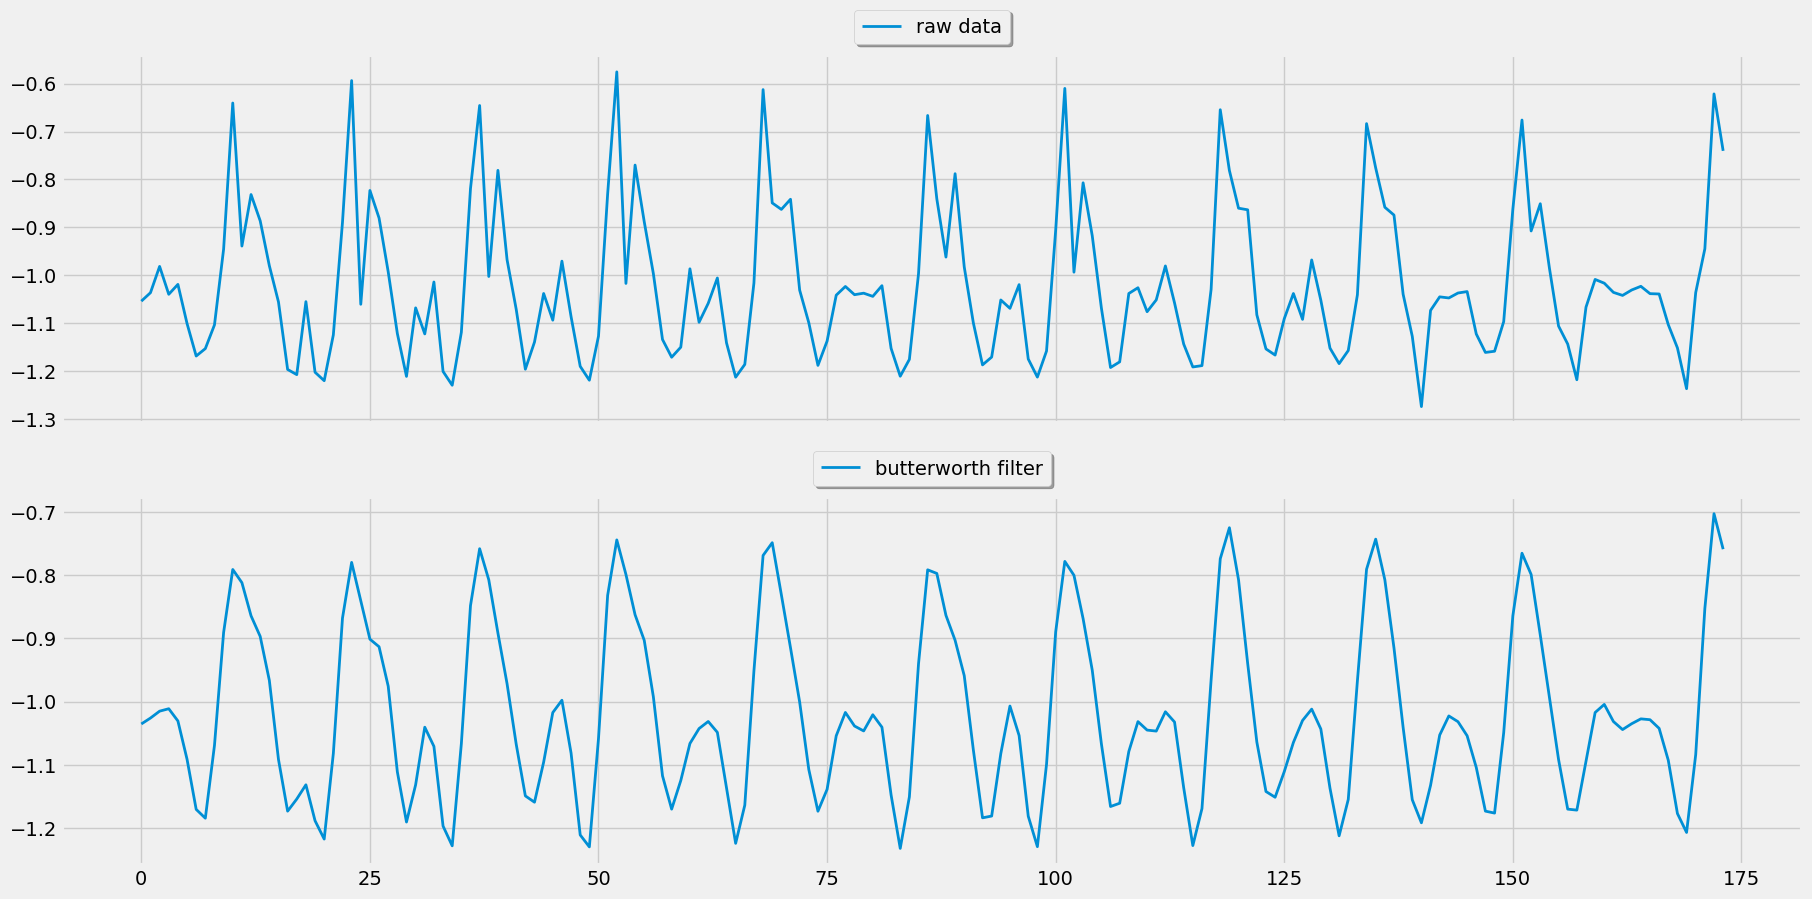

In [13]:
df_lowpass = df.copy()
LowPass = LowPassFilter()

fs = 1000 / 200
cutoff = 1.2

df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"].iloc[0])

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=True)

for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

#### Principal component Analysis (PCA)

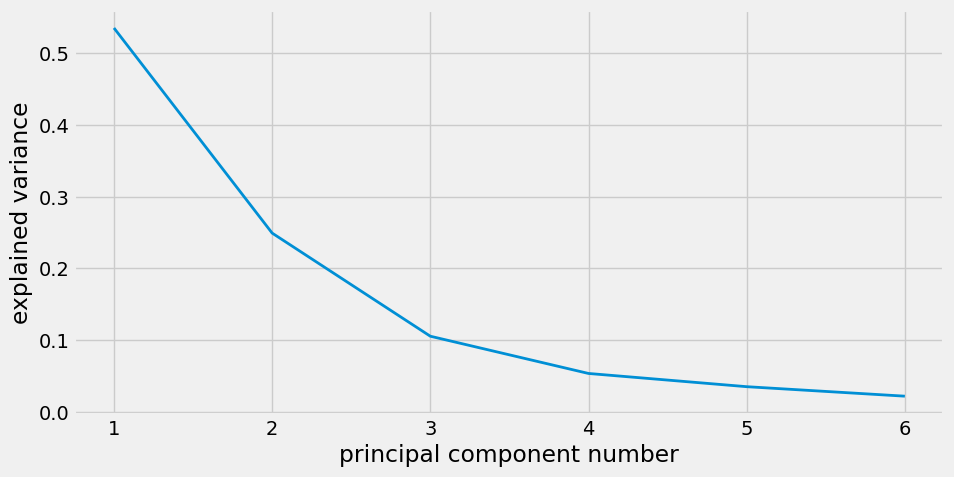

<Axes: xlabel='epoch (ms)'>

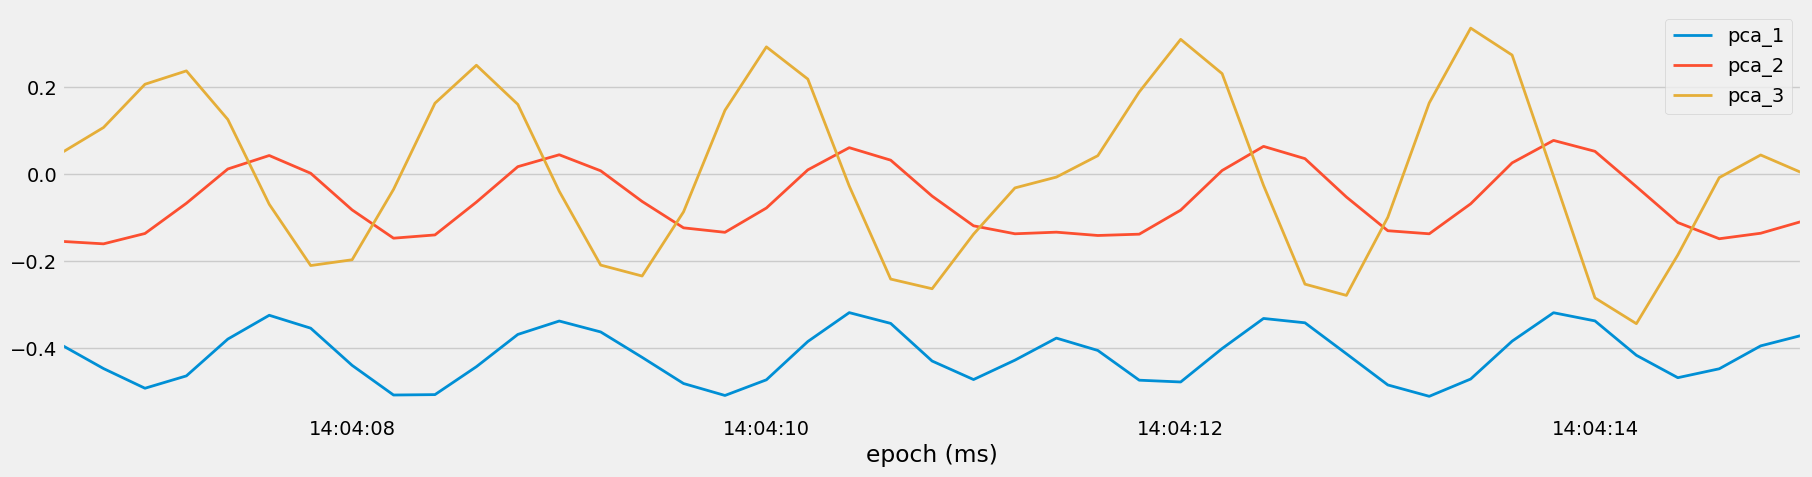

In [14]:
df_pca = df_lowpass.copy()
PCA = PrincipalComponentAnalysis()

pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(predictor_columns) + 1), pc_values)
plt.xlabel("principal component number")
plt.ylabel("explained variance")
plt.show()

df_pca = PCA.apply_pca(df_pca, predictor_columns, 3)

subset = df_pca[df_pca["set"] == 35]
subset[["pca_1", "pca_2", "pca_3"]].plot()

In [15]:
df_pca.head()

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,duration,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977000,-0.070995,-1.894755,2.439078,0.939616,B,bench,heavy,64,16.0,0.342985,-0.087681,-0.010357
2019-01-11 15:08:05.400,0.006869,0.963719,-0.067545,1.835465,0.528684,-1.248135,B,bench,heavy,64,16.0,0.338761,-0.086805,0.027021
2019-01-11 15:08:05.600,-0.009603,0.965713,-0.073447,3.875216,-2.092254,-0.929804,B,bench,heavy,64,16.0,0.341186,-0.093722,0.040051
2019-01-11 15:08:05.800,-0.022998,0.975469,-0.083731,2.421934,-3.626297,0.880509,B,bench,heavy,64,16.0,0.346164,-0.102884,0.020509
2019-01-11 15:08:06.000,-0.020032,0.962501,-0.093783,1.732443,-1.219907,-2.260590,B,bench,heavy,64,16.0,0.341027,-0.108250,0.030559


We can check that there are pca_1, pca_2, pca_3 featuers are added in the dataset.

#### Sum of Squares Attribute (Magnitude)

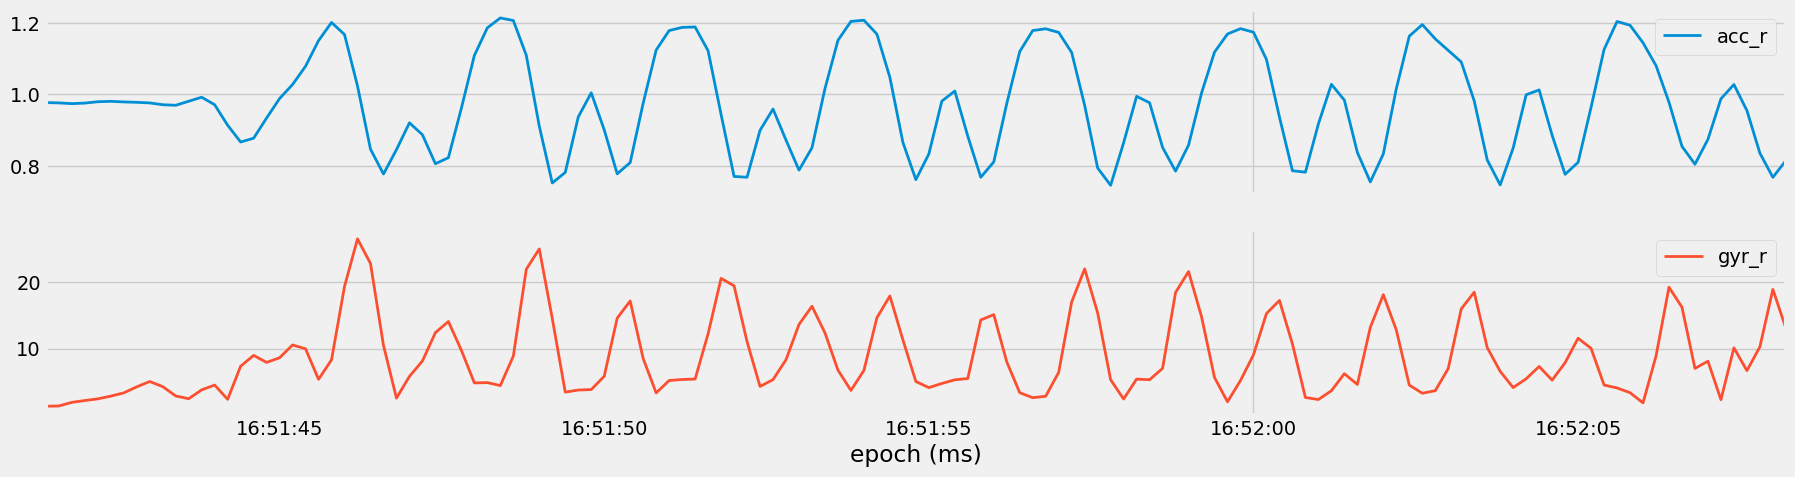

In [16]:
df_squared = df_pca.copy()

acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2

df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

subset = df_squared[df_squared["set"] == 14]
subset[["acc_r", "gyr_r"]].plot(subplots=True)
plt.show()

#### Temporal Abstraction (Mean and Standard Deviation)

<Axes: xlabel='epoch (ms)'>

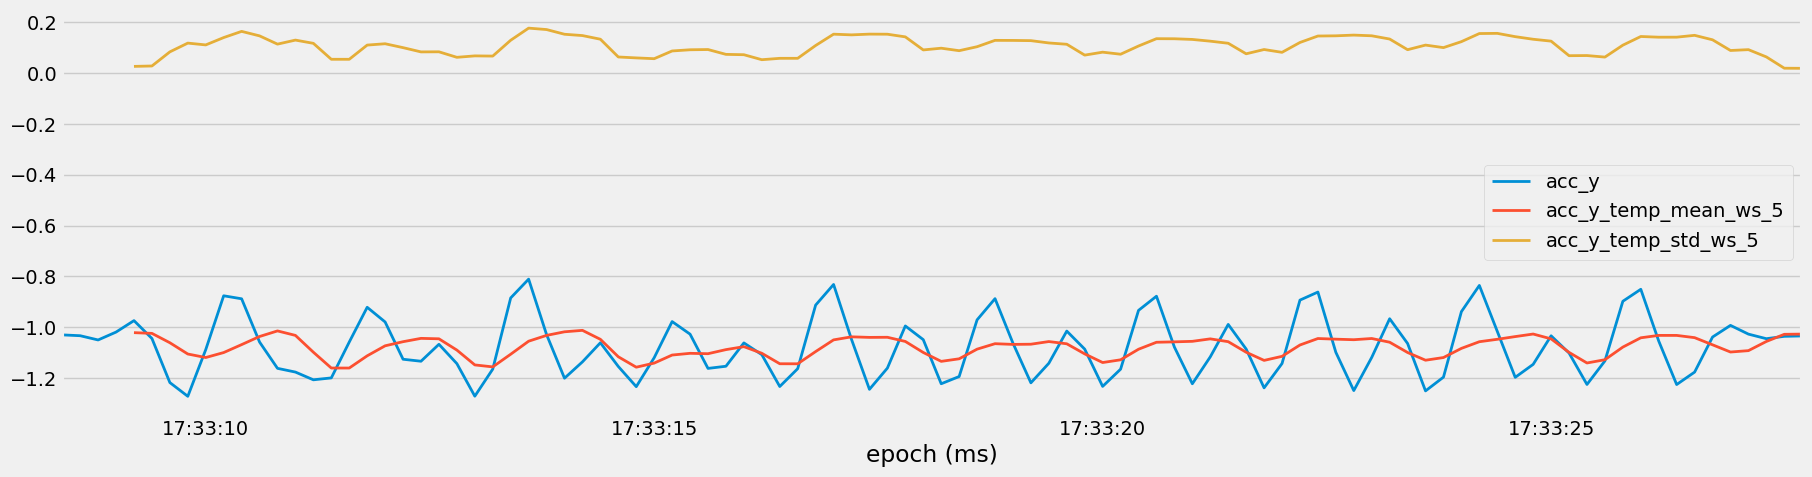

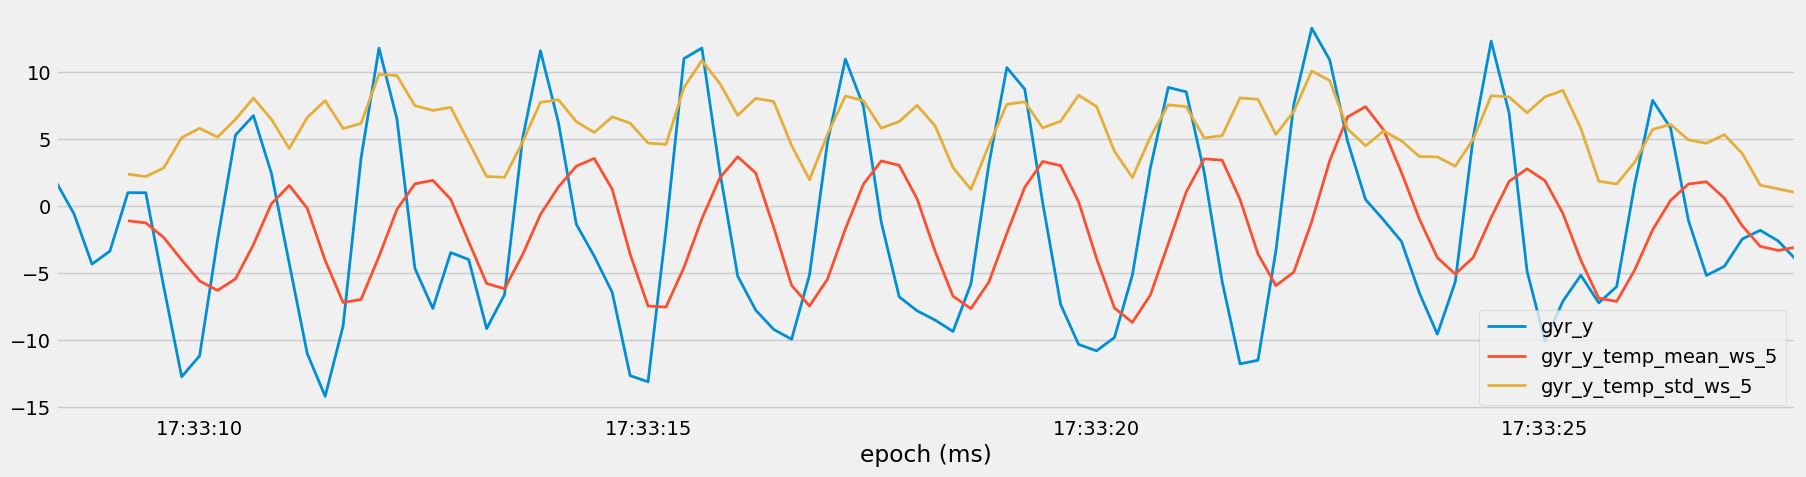

In [17]:
df_temporal = df_squared.copy()
Numabs = NumericalAbstraction()

predictor_columns = predictor_columns + ["acc_r", "gyr_r"]

ws = int(1000 / 200)

for col in predictor_columns:
    df_temporal = Numabs.abstract_numerical(df_temporal, [col], ws, "mean")
    df_temporal = Numabs.abstract_numerical(df_temporal, [col], ws, "std")

df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in predictor_columns:
        subset = Numabs.abstract_numerical(subset, [col], ws, "mean")
        subset = Numabs.abstract_numerical(subset, [col], ws, "std")
    df_temporal_list.append(subset)

df_temporal = pd.concat(df_temporal_list)

subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot()
subset[["gyr_y", "gyr_y_temp_mean_ws_5", "gyr_y_temp_std_ws_5"]].plot()

In [18]:
df_temporal.columns

Index(['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'participant',
       'label', 'category', 'set', 'duration', 'pca_1', 'pca_2', 'pca_3',
       'acc_r', 'gyr_r', 'acc_x_temp_mean_ws_5', 'acc_x_temp_std_ws_5',
       'acc_y_temp_mean_ws_5', 'acc_y_temp_std_ws_5', 'acc_z_temp_mean_ws_5',
       'acc_z_temp_std_ws_5', 'gyr_x_temp_mean_ws_5', 'gyr_x_temp_std_ws_5',
       'gyr_y_temp_mean_ws_5', 'gyr_y_temp_std_ws_5', 'gyr_z_temp_mean_ws_5',
       'gyr_z_temp_std_ws_5', 'acc_r_temp_mean_ws_5', 'acc_r_temp_std_ws_5',
       'gyr_r_temp_mean_ws_5', 'gyr_r_temp_std_ws_5'],
      dtype='object')

We can check that mean_ws_5 and std_ws_5 are added for the features.

#### Fourier Transformation (Frequency Abstraction)

In [19]:
df_freq = df_temporal.copy().reset_index()
FreqAbs = FourierTransformation()

fs = int(1000 / 200)
ws = int(2800 / 200)

df_freq = FreqAbs.abstract_frequency(df_freq, ["acc_y"], ws, fs)

df_freq_list = []
for s in df_freq["set"].unique():
    print(f"Applying Fourier transformations to set {s}")
    subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
    subset = FreqAbs.abstract_frequency(subset, predictor_columns, ws, fs)
    df_freq_list.append(subset)
    
df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop = True)

df_freq = df_freq.dropna()
df_freq = df_freq.iloc[::2]


Applying Fourier transformations to set 64
Applying Fourier transformations to set 72
Applying Fourier transformations to set 40
Applying Fourier transformations to set 86
Applying Fourier transformations to set 80
Applying Fourier transformations to set 10
Applying Fourier transformations to set 74
Applying Fourier transformations to set 52
Applying Fourier transformations to set 12
Applying Fourier transformations to set 33
Applying Fourier transformations to set 77
Applying Fourier transformations to set 53
Applying Fourier transformations to set 32
Applying Fourier transformations to set 79
Applying Fourier transformations to set 22
Applying Fourier transformations to set 17
Applying Fourier transformations to set 69
Applying Fourier transformations to set 63
Applying Fourier transformations to set 60
Applying Fourier transformations to set 92
Applying Fourier transformations to set 57
Applying Fourier transformations to set 7
Applying Fourier transformations to set 16
Applying Fou

In [20]:
np.sort(df_freq.columns)

array(['acc_r', 'acc_r_freq_0.0_Hz_ws_14', 'acc_r_freq_0.357_Hz_ws_14',
       'acc_r_freq_0.714_Hz_ws_14', 'acc_r_freq_1.071_Hz_ws_14',
       'acc_r_freq_1.429_Hz_ws_14', 'acc_r_freq_1.786_Hz_ws_14',
       'acc_r_freq_2.143_Hz_ws_14', 'acc_r_freq_2.5_Hz_ws_14',
       'acc_r_freq_weighted', 'acc_r_max_freq', 'acc_r_pse',
       'acc_r_temp_mean_ws_5', 'acc_r_temp_std_ws_5', 'acc_x',
       'acc_x_freq_0.0_Hz_ws_14', 'acc_x_freq_0.357_Hz_ws_14',
       'acc_x_freq_0.714_Hz_ws_14', 'acc_x_freq_1.071_Hz_ws_14',
       'acc_x_freq_1.429_Hz_ws_14', 'acc_x_freq_1.786_Hz_ws_14',
       'acc_x_freq_2.143_Hz_ws_14', 'acc_x_freq_2.5_Hz_ws_14',
       'acc_x_freq_weighted', 'acc_x_max_freq', 'acc_x_pse',
       'acc_x_temp_mean_ws_5', 'acc_x_temp_std_ws_5', 'acc_y',
       'acc_y_freq_0.0_Hz_ws_14', 'acc_y_freq_0.357_Hz_ws_14',
       'acc_y_freq_0.714_Hz_ws_14', 'acc_y_freq_1.071_Hz_ws_14',
       'acc_y_freq_1.429_Hz_ws_14', 'acc_y_freq_1.786_Hz_ws_14',
       'acc_y_freq_2.143_Hz_ws_14', 'a

By applying the Fourier Transform, this code extracts key frequency-domain features that describe the periodic behavior of the signals over time:

- Max Frequency: Indicates the strongest frequency component.
- Frequency Weighted Average: Highlights dominant frequencies by weighting.
- Power Spectral Entropy (PSE): Shows signal complexity, helping differentiate between repetitive and irregular signals.
- Specific Frequencies: Measures signal strength at predefined frequencies, useful for identifying specific patterns like walking (if periodic) or vibrations.

#### K-Means Clustering

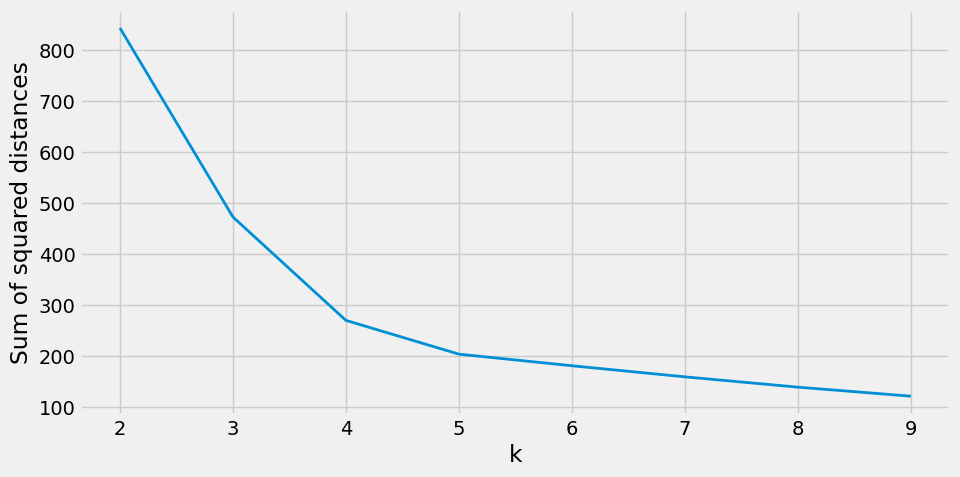

In [21]:
df_cluster = df_freq.copy()

cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2,10)
inertias = [] #inertia: sum of squared distances from each point to its assigned cluster center

for k in k_values:
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters= k, n_init = 20, random_state = 0)
    cluster_labels = kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(k_values, inertias)
plt.xlabel("k")
plt.ylabel("Sum of squared distances")
plt.show()

The elbow method is a common approach to choose the optimal number of clusters in K-Means.
We can assume that k = 5 is a optimal number by looking the plot.

#### 3D Scatter Plot of Clusters

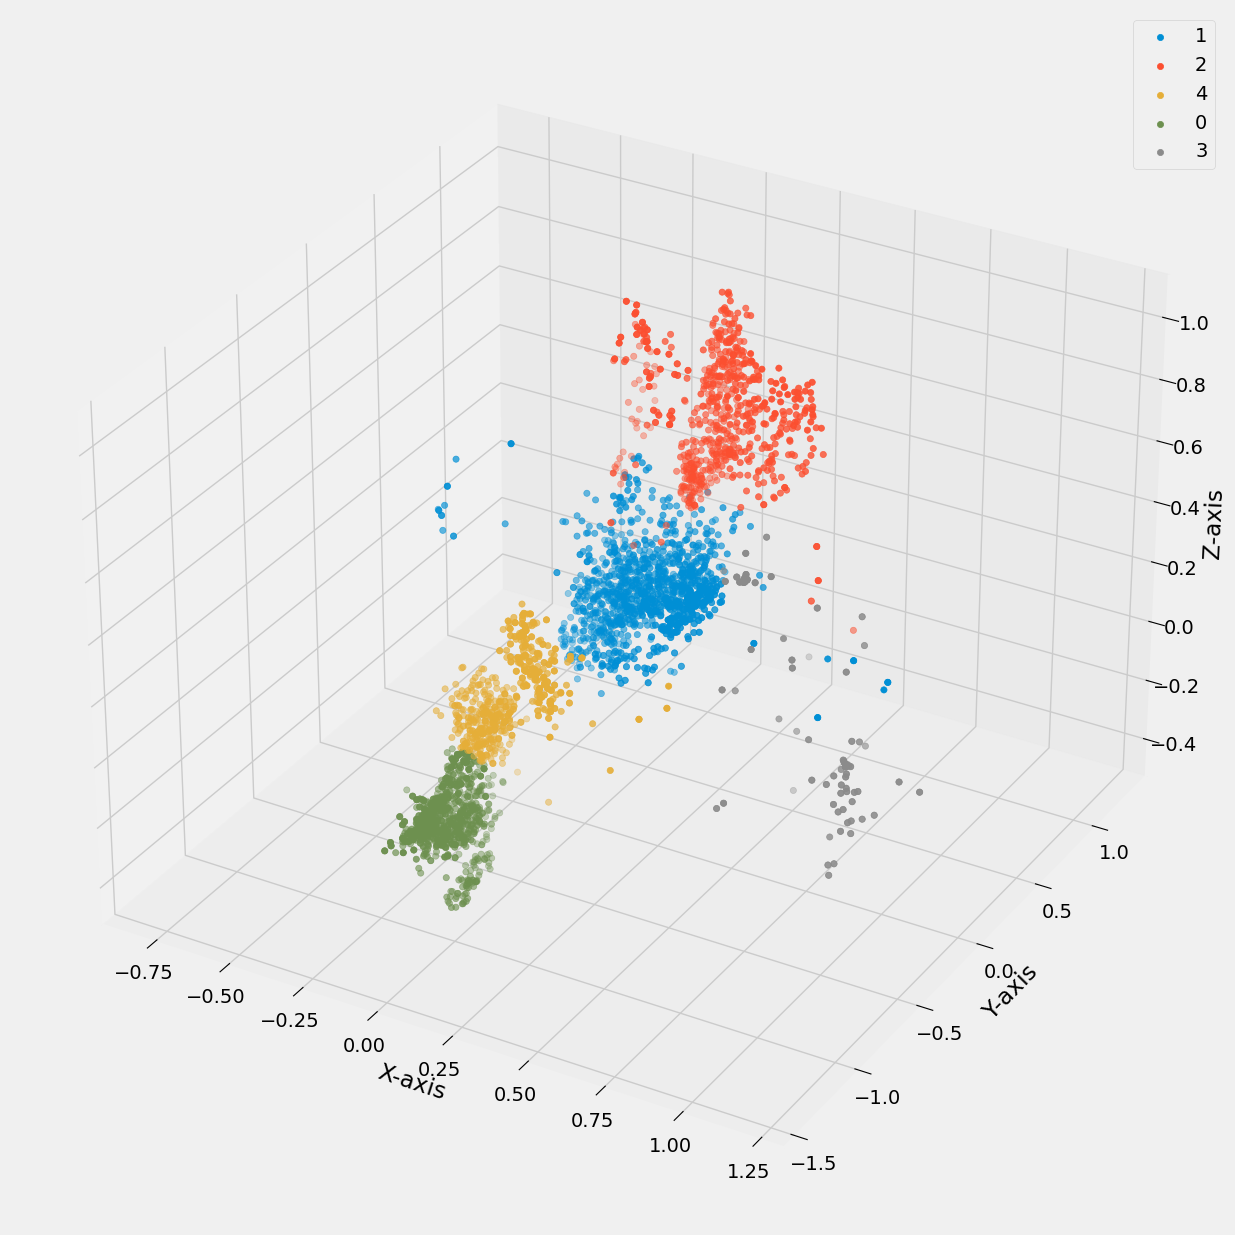

In [22]:
kmeans = KMeans(n_clusters= 5, n_init = 20, random_state = 0)
subset = df_cluster[cluster_columns]
df_cluster["cluster"] = kmeans.fit_predict(subset)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection="3d")
for c in df_cluster["cluster"].unique():
    subset = df_cluster[df_cluster["cluster"] == c]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label = c)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

#### 3D Scatter Plot of Original Labels

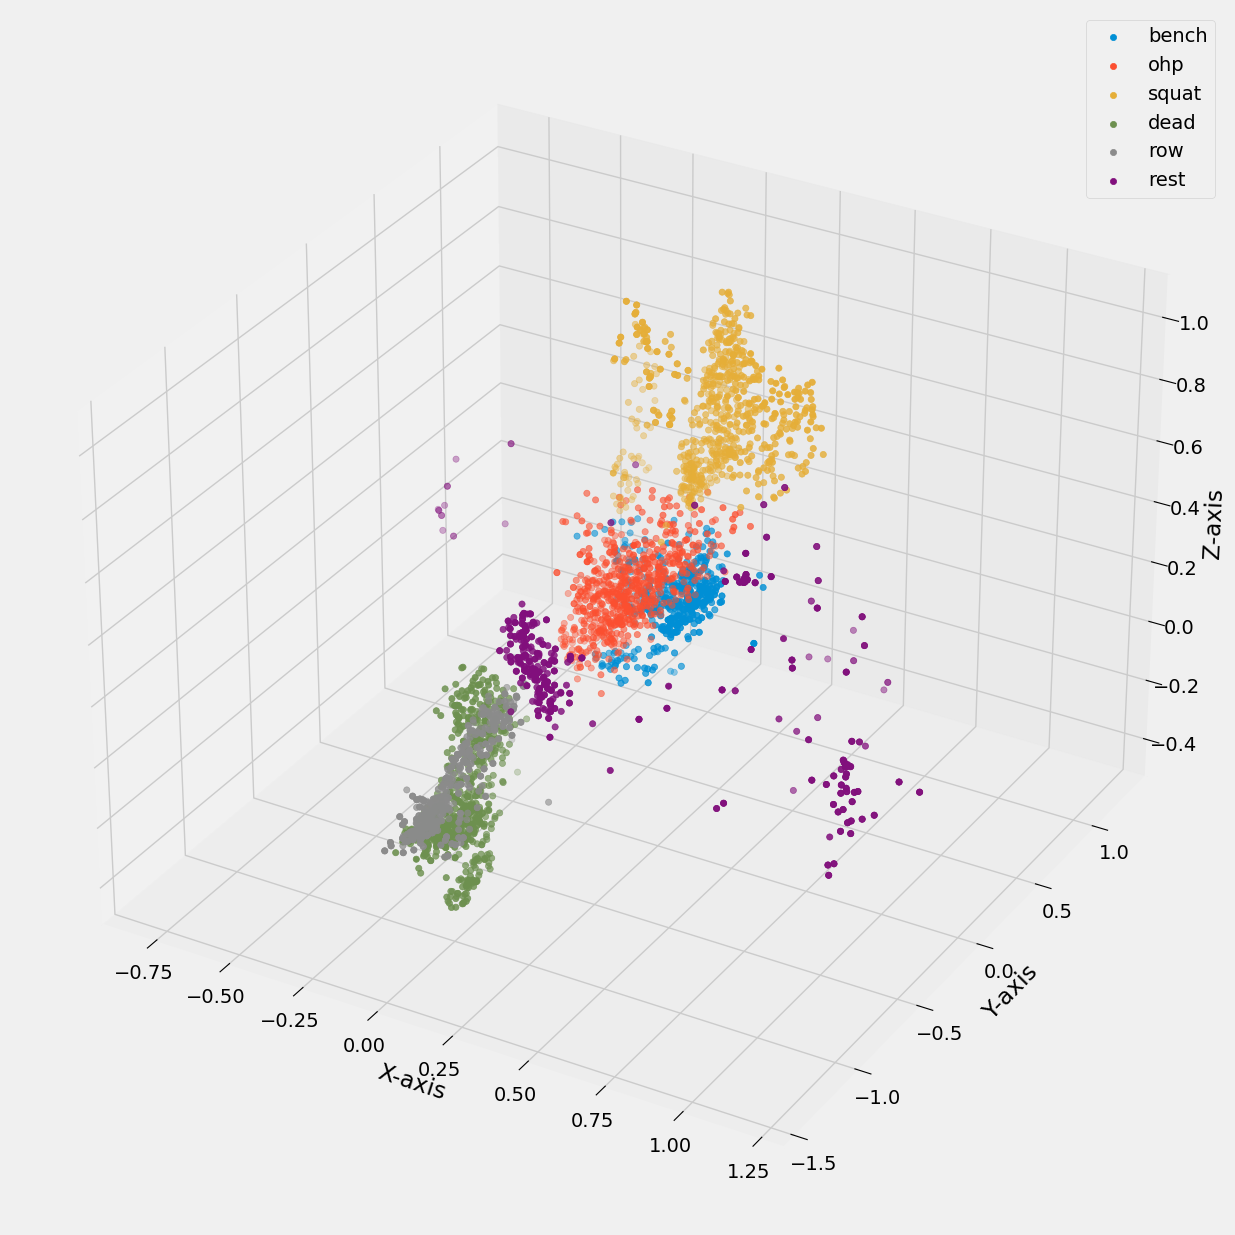

In [23]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection="3d")
for l in df_cluster["label"].unique():
    subset = df_cluster[df_cluster["label"] == l]
    ax.scatter(subset["acc_x"], subset["acc_y"], subset["acc_z"], label = l)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.legend()
plt.show()

## Model Building

#### Split training and test set

In [24]:
df = df_cluster

df_train = df.drop(["participant", "category", "set"], axis=1)

X = df_train.drop("label", axis=1)
y = df_train["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### Creating Feature Subsets for Comparision
- Feature Set 1: Basic Features(ex. acc_x)
- Feature Set 2: Basic Features + Sum of Squared Features(ex. acc_r) + PCA Features(ex. pac_1)
- Feature Set 3: Basic Features + Sum of Squared Features + PCA Features + Temporal Abstraction Features
- Feature Set 4: Basic Features + Sum of Squared Features + PCA Features + Temporal Abstraction Features + Frequency Abstraction Features

In [25]:
basic_features = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]
square_features = ["acc_r", "gyr_r"]
pca_features = ["pca_1", "pca_2", "pca_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
freq_features = [f for f in df_train.columns if (("_freq" in f) or ("_pse" in f))]
cluster_features = ["cluster"]

feature_set_1 = list(set(basic_features))
feature_set_2 = list(set(basic_features + square_features + pca_features))
feature_set_3 = list(set(feature_set_2 + time_features))
feature_set_4 = list(set(feature_set_3 + freq_features + cluster_features))

#### Model comparision
- Neural Network
- Random Forest
- KNN
- Decision Tree
- Naive Bayes

In [26]:
learner = ClassificationAlgorithms()

possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
]

feature_names = [
    "Feature Set 1",
    "Feature Set 2",
    "Feature Set 3",
    "Feature Set 4",
]

iterations = 1
score_df = pd.DataFrame()

for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = X_train[possible_feature_sets[i]]
    selected_test_X = X_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


In [27]:
score_df.sort_values("accuracy", ascending= False)

,model,feature_set,accuracy
0,NN,Feature Set 4,0.997416
1,RF,Feature Set 4,0.996124
1,RF,Feature Set 3,0.990956
0,NN,Feature Set 3,0.988372
3,DT,Feature Set 4,0.987080
4,NB,Feature Set 4,0.984496
4,NB,Feature Set 3,0.968992
1,RF,Feature Set 1,0.963824
1,RF,Feature Set 2,0.959948
3,DT,Feature Set 3,0.959948


We can see that Random Forest Model and Neural Network Model with Feature Set 4 has the highest accuracy score.
I will use Random Forest Model for the classification.

#### Confusion Matrix

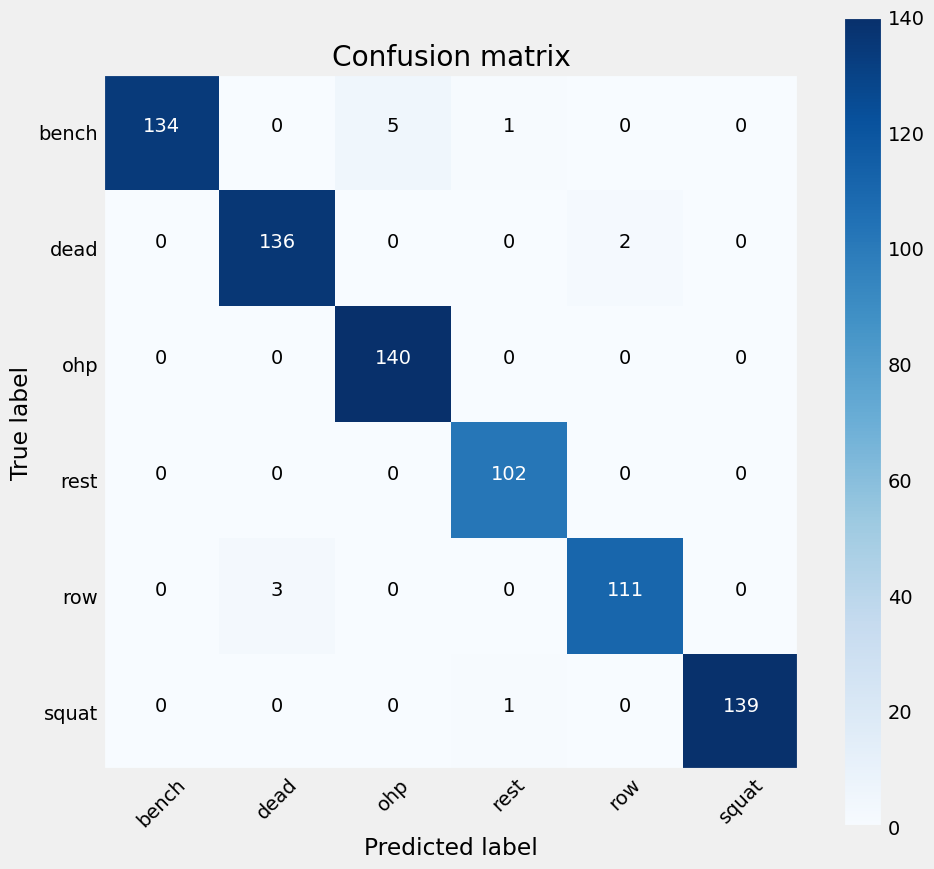

In [28]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

The confusion matrix told us the following.
- There is a slight confusion between Row and Deadlift.
- There is a slight confusion between Overhead Press and Bench Press.

It seems quite reasonable to confuse those barbell exercises because they have a similar mechanism

## Outcome

- Machine Learning Model for classifying Barbell Exercise is successfully built using a Random Forest Model with a high accuracy score(0.996 ~ 0.998).
- The random Fores Model and Neural Network model showed the highest accuracy score(0.996 ~ 0.998) when the models were used with feature set 4 (Basic Features + Sum of Squared Features + PCA Features + Temporal Abstraction Features + Frequency Abstraction Features).
- The model was a bit confused between the Overhead Press and Bench Press, as well as between the Row and Deadlift.